# COMP425/6341 Computer Vision - Project skeleton

## 0 Import KMNIST dataset (1 pts)

In [109]:
# import required libraries, DO NOT MODIFY!
# activate pytorch_p37 to activate pytorch
import torch
import torchvision
from torchvision.datasets import ImageFolder,KMNIST
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
import numpy as np

In [110]:
### TODO: set random seed to your Student ID
random_seed = 40076164
torch.manual_seed(random_seed);

Run the cells below to initialize the train and test loaders for KMNIST and visualize one of its samples.

**Experiments:** <br>
1. Change `batch_size` based on the device you are using.<br>
2. Try more complicated transformations on train set.<br>
3. Visualize different samples from the dataset.

In [111]:
# datasets hyper parameters
batch_size = 20
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# Initialize kmnist train and test datasets
# These two lines will download the datasets in a folder called KMNIST.
# The folder will be written in the same directory as this script.
# The download will occur once. Subsequent executions will not re-download the datasets if they eforxist.
kmnist_train_set = KMNIST(root='.',
                         train=True,
                         download=True,
                         transform=train_transform)
kmnist_test_set = KMNIST(root='.',
                         train=False,
                         download=True,
                         transform=test_transform)

# Initialize kmnist train and test data loaders. 
kmnist_train_loader = torch.utils.data.DataLoader(kmnist_train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)
kmnist_test_loader = torch.utils.data.DataLoader(kmnist_test_set,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

Labels:  [5 3 0 6 8 8 1 7 2 7 9 1 2 0 8 4 4 7 1 0]
(3, 92, 242)
(92, 242, 3)


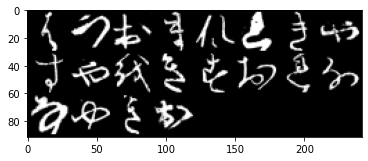

In [112]:
### TODO: visualize a sample image and corresponding label from KMNIST
iter_images = iter(kmnist_train_loader)
kmnist_images, kmnist_labels = iter_images.next()
np_labels = kmnist_labels.numpy()
label_string = np.array2string(np_labels)
print('Labels: ',label_string)
image_grid = torchvision.utils.make_grid(kmnist_images)
np_image = image_grid.numpy()
print(np_image.shape)
image_transpose = np.transpose(np_image, (1, 2, 0)) # Used to fix the shape of the image grid. Before this operation,
                                                    # it is a vertical image instead of horizontal
print(image_transpose.shape)
plt.imshow(image_transpose) 

## 1 Feed-forward Neural network
In this section, you will implement a simple feed-forward network from scratch. Follow the instructions/comments in each subsection to complete the general structure of the network.

### 1.1 Activation Functions (4 + 4 + 4 pts)
Implement [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and [Identity](https://en.wikipedia.org/wiki/Identity_function) functions. This functions will later be used in network architecture.

In [113]:
def Sigmoid(x):
    """ Sigmoid activation function --> S(x) = 1 / 1 + e^-x
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """
    ### TODO: Fill out this function
    sig = 1 / 1 + torch.exp(-x)
    # sig = torch.sigmoid(x)
    return sig


def ReLU(x):
    """ ReLU activation function
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """
    ### TODO: Fill out this function
    x[x < 0] = 0
    return x

def Identity(x):
    """ Identity activation function
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """
    ### TODO: Fill out this function
    return x

### 1.2 Cross Entropy Loss (7.5 + 7.5 pts)
Implement the Softmax function and Cross Entropy loss.

In [114]:
def Softmax(x,dim):
    """ Softmax function
    Args:torch.log(
        x (torch.tensor): inputs tensor of size (B,F)
        dim (int): A dimension along which Softmax will be computed
    Return:
        torch.tensor: a tensor of shape of x
    """
    # print("softmax x shape", x.shape)
    ### TODO: Fill out this function
    tensor_probabilities = torch.zeros(x.shape)
    iteration = 0
    removed_max = x - x.max() # Remove very large values
    x = removed_max
    
    for value in x: # x is a 2D tensor containing each image
        tensor_exp = torch.exp(value)
        tensor_probabilities[iteration] = tensor_exp / torch.sum(tensor_exp, dim=dim)
        iteration += 1
    tensor_probabilities += 0.000001 # Add a small decimal number to avoid 0 values
    # print("softmax probability shape", tensor_probabilities.shape)
    return tensor_probabilities

def CE_loss(predictions,labels):
    """ Cross entropy loss
    Args:
        predictions (torch.tensor): tensor of shape of (B,C)
        labels (torch.tensor): tensor of shape of (B,1)
    Returns:
        torch.tensor: a tensor of shape of (1,)
    """
    ### TODO: Fill out this function
    softmax_probility = Softmax(predictions, 0)
    # print("softmax shape", softmax_probility.shape)
    celoss = torch.zeros(labels.shape[0])
    
    for label_index in range(labels.shape[0]):
        image_class_label = labels[label_index]
        celoss[label_index] = -1 * torch.log(softmax_probility[label_index][image_class_label])
        # print("after celoss", -1 * torch.log(softmax_probility[label_index][image_class_label]))
    
    return celoss.mean()

# tens = torch.tensor([[3.2,1.3,0.2,0.8]])
# label = torch.tensor([0,1,0,0])

# print(kmnist_labels)
# CE_loss(kmnist_images, kmnist_labels)

### 1.3 Network (2.5 + 7.5 pts)
Complete the code for the simple feed-forward network shown below. 

Network parameters will be stored in a dictionary called `params`. weights and biases keys appear in the format `W#` and `b#` where `#` indicates the layer number. For example, the weights and biases of the first layer are `W1` and `b1`. Weights and biases are initialized inside `init_weights` function.

**Notes:** 
1. Set `requires_grad=True` when initializing weights and biases to have [pytorch automatic differentiation engine](https://pytorch.org/docs/stable/autograd.html) calculate the gradients.
2. Assign network parameters and inputs on the same `device`.
3. Initialize weights and biases with samples from normal distribution with mean 0 and variance 1.

In [115]:
params = {}

class my_nn:
    def __init__(self,layers_dim,layers_activation=None,device='cpu'):
        """ Initialize network
        Args:
            layers_dim (List of ints): list of Size of each layer of the network
                                        [inputs,layer1,...,outputs]
            layers_activation (List of strings): list of activation function for each hidden layer
                                        of the network[layer1,...,outputs]
            device (str): a device that will be used for computation
                Default: 'cpu'
            
        """
        self.layers_activation = layers_activation
        self.params = {}
        self.num_layers = len(layers_dim)-1
        self.layers_dim = layers_dim
        self.device = device
        self.init_weights()

    def init_weights(self):
        """ Initialize weights and biases of network based on layers dimension.
            Store weights and biases in self.params.
            weights and biases key should be of format "W#" and "b#" where # is the layer number.
            Example: for layer 1, weight and bias key is "W1" and "b1"
        Args:
            None
        
        Returns:
            None
        """
        ### TODO: Initialize weights and bias of network
        ### TODO: Store weights and biases in self.params
        ### HINT: Remember to set require_grad to True
        ### HINT: Remember to put tensors of target device
        
        # Init weights & bias
        for dim in range(0, len(self.layers_dim) - 1, 1):
            current_layer = self.layers_dim[dim]
            next_layer = self.layers_dim[dim + 1]
            c_layer_dimension = np.array([current_layer])
            sqrt_layer = np.sqrt(1./c_layer_dimension) # Used to avoid high values (aka NAN values)
            rooted = sqrt_layer[0]
            
            # Weights from current -> next layer
            
            # Multiply by rooted to effectively clamp the standard deviation to about 1 based on layer dim
            layered_nodes = torch.randn(current_layer, next_layer, device=self.device) * rooted
            layered_nodes.requires_grad = True
            layered_nodes = layered_nodes.float()
            # print("weights", layered_nodes)
            
            # Bias for layer
            bias = torch.randn(next_layer, device=self.device) * rooted
            bias.requires_grad = True
            bias = bias.float()
            w = 'W' + str(dim + 1)
            b = 'b' + str(dim + 1)
            self.params[w] = layered_nodes
            self.params[b] = bias

            

    def forward(self,x):
        """ Perform forward pass
        Args:
            x (torch.tensor): tensor of shape of (B, C, H, W)
        
        Return:
            torch.tensor: tensor of shape of (B, N_classes)
        """
        ### TODO: Fill out this function
        for_pass_nn = torch.zeros(batch_size, 10, device=self.device)
        for b_index in range(len(x)):
            image = x[b_index][0]
            image = image.reshape(28 * 28).to(self.device)
            for_pass = 0
            
            for layer_index in range(0, self.num_layers):
                if self.layers_activation[b_index] == "sigmoid":
                    image = Sigmoid(
                                    (image @ self.params['W' + str(layer_index + 1)]) + self.params['b' + str(layer_index + 1)])
                elif self.layers_activation[b_index] == "relu":
                    # print("image shape", image.shape)
                    # print("bias shape", self.params['b' + str(layer_index + 1)].shape)
                    # print("weight shape", self.params['W' + str(layer_index + 1)].shape)
                    image = ReLU(
                                    (image @ self.params['W' + str(layer_index + 1)]) + self.params['b' + str(layer_index + 1)])
                    # print("after activation", image)
                elif self.layers_activation[b_index] == "identity":
                    image = Identity(
                                    (image @ self.params['W' + str(layer_index + 1)]) + self.params['b' + str(layer_index + 1)])

            for_pass_nn[b_index] = image
            # print("in f_nn", image)
        
        return for_pass_nn
    
    
# layers_dim = [28*28,512,512,10]
# layer_activation_fn = []
# model = my_nn(layers_dim, layer_activation_fn, device=device)

### 1.4 Training the network (12+12+6 pts)
Complete and run the following cells to train the network. You can use the predefined network hyper parameters or try your own.

In [116]:
def Train(model,optimizer,dataloader,device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        optimizer (torch.optim instance)
        dataloader (torch.utils.data.DataLoader instance): dataloader for train set
        device (str): computation device ['cpu','cuda',...]
    Returns:
        list of floats: mini_batch loss sampled every 20 steps for visualization purposes
        list of floats: mini_batch accuracy sampled every 20 steps for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    
    for i,(data,label) in enumerate(dataloader):
        # https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
        # https://www.youtube.com/watch?v=oPhxf2fXHkQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=13
        ### TODO: Put data and label on target device
        # data = data.reshape(-1, 28*28).to(device)
        data = data.to(device)
        label = label.to(device)
        
        ### TODO: Set gradients to zero to clear previous gradients
        optimizer.zero_grad()
        
        ### TODO: Pass data to the model
        neural_network = model.forward(data)
        
        ### TODO: Calculate the loss of predicted labels vs ground truth labels
        loss = CE_loss(neural_network, label)
        # print("loss before backprop", loss)
        
        ### TODO: Calculate gradients and update weights and biases
        loss.backward()  # Backpropagation
        # print("loss after backprop", loss)
        optimizer.step() # Update the weights & bias
            
        if i % batch_size:
            with torch.no_grad():
                loss_tracker.append(loss.item())
                accuracy = 0
                ### TODO: calculate accuracy of mini_batch
                for index in range(0, neural_network.shape[0]):
                    
                    one_prediction = neural_network[index]
                    one_prediction_index = torch.argmax(one_prediction)
                    one_label = label[index]
                    
                    if one_label == one_prediction_index:
                        accuracy+=1
                accuracy_tracker.append(accuracy/data.size(0))
            
    return loss_tracker, accuracy_tracker

def Test(model,dataloader,device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        dataloader (torch.utils.data.DataLoader instance)
        device (str): computation device ['cpu','cuda',...]
    Returns:
        floats: test set loss for visualization purposes
        floats: test set accuracy for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    
    for i,(data,label) in enumerate(dataloader):
        ### TODO: Put data and label on target device
        # data = data.reshape(-1, 28*28).to(device)
        data = data.to(device)
        label = label.to(device)
        
        with torch.no_grad():
            ### TODO: Pass data to the model
            image_nn = model.forward(data)
            ### TODO: Calculate the loss of predicted labels vs ground truth labels
            loss = CE_loss(image_nn, label)
            accuracy = 0
            ### TODO: calculate accuracy of mini_batch
            for index in range(0, image_nn.shape[0]):
                one_prediction = image_nn[index]
                one_prediction_index = torch.argmax(one_prediction)
                one_label = label[index]
                    
                if one_label == one_prediction_index:
                    accuracy+=1
                    
        loss_tracker.append(loss.item())
        accuracy_tracker.append(accuracy/data.size(0))
        
    return sum(loss_tracker)/len(loss_tracker), sum(accuracy_tracker)/len(accuracy_tracker)
        

In [162]:
# Training hyper parameters
epochs = 10
learning_rate = 0.00001
layers_dim = [28*28,512,512,10]
layer_activation_fn = []

for x in range(layers_dim[0]):
    layer_activation_fn.append("relu")

### TODO: Set target device for computations
device = 'cuda'
print(f'device: {device}')


### TODO: Initialize model using layers_dim
model = my_nn(layers_dim, layer_activation_fn, device=device)
### TODO: Initialize Adam optimizer
param_list = []

for key, value in model.params:
    param_list.append(model.params[key + value])

# print(model.params)        
optimizer = torch.optim.Adam(param_list, lr=learning_rate)

train_loss_tracker = []
train_accuracy_tracker = []

test_loss_tracker = []
test_accuracy_tracker = []
train_loss_plot = []
train_accuracy_plot = []

for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}')
    train_loss,train_accuracy = Train(model,optimizer,kmnist_train_loader,device)
    test_loss , test_accuracy = Test(model,kmnist_test_loader,device)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))
    train_loss_plot.append(sum(train_loss)/len((train_loss))
    train_accuracy_plot.append(sum(train_accuracy)/len((train_accuracy))
    plt.plot(train_accuracy_tracker, epoch, label='Training')
    plt.plot(test_accuracy_tracker, epoch, label='Testing')

device: cuda
Epoch: 1
	 training loss/accuracy: 1.31/0.65
	 testing loss/accuracy: 1.25/0.63
Epoch: 2
	 training loss/accuracy: 0.79/0.77
	 testing loss/accuracy: 1.09/0.67
Epoch: 3
	 training loss/accuracy: 0.70/0.79
	 testing loss/accuracy: 1.01/0.69
Epoch: 4
	 training loss/accuracy: 0.64/0.80
	 testing loss/accuracy: 0.96/0.70
Epoch: 5
	 training loss/accuracy: 0.60/0.81
	 testing loss/accuracy: 0.91/0.71
Epoch: 6
	 training loss/accuracy: 0.57/0.82
	 testing loss/accuracy: 0.89/0.72
Epoch: 7
	 training loss/accuracy: 0.55/0.83
	 testing loss/accuracy: 0.85/0.73
Epoch: 8
	 training loss/accuracy: 0.52/0.83
	 testing loss/accuracy: 0.82/0.74
Epoch: 9
	 training loss/accuracy: 0.50/0.84
	 testing loss/accuracy: 0.80/0.75
Epoch: 10
	 training loss/accuracy: 0.49/0.84
	 testing loss/accuracy: 0.77/0.75


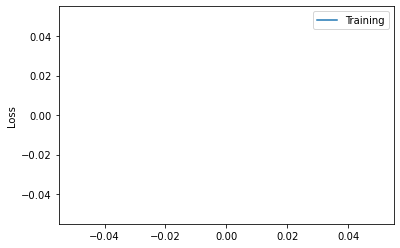

In [126]:
### TODO: visualize train_loss and train_accuracy
### TODO: visualize test_loss and test_accuracy
plt.plot(test_loss_tracker, label='Training')
#plt.plot(test_accuracy_tracker, label='Testing')
plt.ylabel("Loss")
plt.legend()

## 2 Convolutional Neural Network (CNN)

Implement a CNN and train your network. Using GPU will dramatically increase the training speed. If you are planning on using [Google Colab](https://colab.research.google.com/), one way to load the dataset is to load it from your google drive. Run the cell below to mount your google drive storage. If you are training on your local machine, comment out the following two lines.

In [68]:
# from google.colab import drive
# drive.mount('/content/drive')
import math

In this section, we will use the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). You only need download [images](http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar) (Extract and upload this folder to your google drive if you are planning to use google colab). 

Run the cells below to load and visualize this dataset.

In [69]:
# load dataset from path
# set path to images location on your local machine or google drive
#path = 'drive/MyDrive/images/Images'  # Google drive
path = './images/Images'               #local machine
dataset = ImageFolder(path)
print(f'number of images: {len(dataset)}')
print(f'number of classes: {len(dataset.classes)}')

number of images: 20580
number of classes: 120


In [70]:
# Create train and test splits of original dataset
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

In [71]:
# In order to apply transformations, we use a custom dataset
# see https://pytorch.org/docs/stable/data.html#iterable-style-datasets
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [72]:
batch_size =64

#train set transforms
train_transform = transforms.Compose([
   transforms.Resize((240, 240)),
    transforms.ToTensor()    
])

# test set transforms
test_transform = transforms.Compose([
    transforms.Resize((240,240)), 
    transforms.ToTensor()
])

# Initialize train and test sets
train_dataset = DogBreedDataset(train_ds, train_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size)

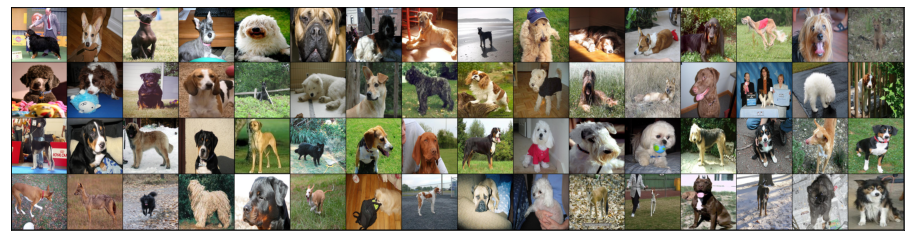

In [73]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break
show_batch(train_dl)

### 2.1 Custom CNN (10* + 2.5 + 12.5 pts)
Create your own `conv_net`. Apply `ReLU` activation function after each convolution layer.

**Extra credit for undergraduates/Compulsory for graduates**: Implement a `my_conv2d` class to replace `torch.nn.Conv2d`.

**Extra credit for all**: Implement [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi]) to initialize network weights. Do not use `torch.nn.init` module for this task.

In [130]:
class my_conv2d:
    ### EXTRA CREDIT FOR UNDERGRADUATES - ### TODO: Compulsory for graduates
    ### Complete this class to have the perform the convolution similar to torch.nn.Conv2d 
    def __init__(self,):
        pass
    
    def forward(self,x):
        pass

    

class conv_net(nn.Module):
    def __init__(self):
        """ Initialize conv_net
        Args:
            None
        Returns:
            None
        """
        super(conv_net,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 100, kernel_size = 11, stride = 3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 100, out_channels = 512, kernel_size = 3, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1)
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 3, stride = 1)
        ### TODO: calculate number of in_features for this layer
        self.linear = nn.Linear(in_features = 256*2*2 , out_features = 120)
        self.init_weights()

    def init_weights(self):
        ### EXTRA CREDIT FOR ALL: initialize network weights based on Xavier initialization
            
        # Weights for each conv layer using Xavier (My own implementation of it)
        # self.conv1.weight = nn.Parameter(torch.Tensor(self.conv1.weight.shape).uniform_(-1, 1) * math.sqrt(6./(self.conv1.weight.shape[0] + self.conv1.weight.shape[1])))
            
        # self.conv2.weight = nn.Parameter(torch.Tensor(self.conv2.weight.shape).uniform_(-1, 1) * math.sqrt(6./(self.conv2.weight.shape[0] + self.conv2.weight.shape[1])))
              
        # self.conv3.weight = nn.Parameter(torch.Tensor(self.conv3.weight.shape).uniform_(-1, 1) * math.sqrt(6./(self.conv3.weight.shape[0] + self.conv3.weight.shape[1])))
        
        # self.conv4.weight = nn.Parameter(torch.Tensor(self.conv4.weight.shape).uniform_(-1, 1) * math.sqrt(6./(self.conv4.weight.shape[0] + self.conv4.weight.shape[1])))
        
        # self.conv5.weight = nn.Parameter(torch.Tensor(self.conv5.weight.shape).uniform_(-1, 1) * math.sqrt(6./(self.conv5.weight.shape[0] + self.conv5.weight.shape[1])))
        
        # self.linear.weight = nn.Parameter(torch.Tensor(self.linear.weight.shape).uniform_(-1, 1) * math.sqrt(6./(self.linear.weight.shape[0] + self.linear.weight.shape[1])))
    
        
        # Weights for each conv layer using Xavier (Pytorch Initialization)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        torch.nn.init.xavier_uniform_(self.conv5.weight)
        torch.nn.init.xavier_uniform_(self.linear.weight)
   
    def forward(self,x):
        """ Perform forward pass
        Args:
            x (torch.tensor): tensor of images of shape  (B, C, H, W)
        Returns:
            torch.tensor: tesnor of output of shape (B, N_classes)
        """
        ### TODO: fill out this function
        
        # Apply Conv and Max Pooling
        x = x.cuda()
        x = ReLU(self.conv1(x))
        x = self.max_pool1(x)
        x = ReLU(self.conv2(x))
        x = ReLU(self.conv3(x))
        x = self.max_pool2(x)
        x = ReLU(self.conv4(x))
        x = ReLU(self.conv5(x))
        x = self.max_pool3(x)
        
        # print("after conv and pooling layers", x.shape)
        
        # Flatten x and pass it into FFNN
        flatten = x.reshape(-1,256*2*2)
        # print("after flatten", flatten.shape)
        x = self.linear(flatten)
        
        return x

### 2.2 Training the network (3.5 + 3.5 pts)
Re-use the previously implemented Train and Test functions. Complete the missing parts below and run cells to train `conv_net` and visualize the training statistics.

device: cuda
epoch: 0
	 training loss/accuracy: nan/0.01
	 testing loss/accuracy: nan/0.01
epoch: 1
	 training loss/accuracy: nan/0.01
	 testing loss/accuracy: nan/0.01


KeyboardInterrupt: 

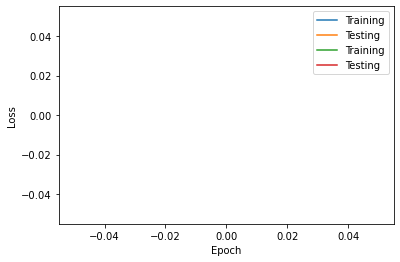

In [108]:
# Training hyper parameters
epochs = 20
learning_rate = 0.0001

### TODO: Set target device for computations
device = 'cuda'
print(f'device: {device}')


### TODO: Initialize conv_net
model = conv_net()
### TODO: Put model parameters on target device
model = model.to(device)
### TODO: Initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss_tracker = []
train_accuracy_tracker = []

test_loss_tracker = []
test_accuracy_tracker = []

for epoch in range(epochs):
    train_loss,train_accuracy = Train(model,optimizer,train_dl,device)
    test_loss , test_accuracy = Test(model,test_dl,device)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print(f'epoch: {epoch}')
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))
    plt.plot(sum(train_loss)/len(train_loss), label='Training')
    plt.plot(test_loss_tracker, label='Testing')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

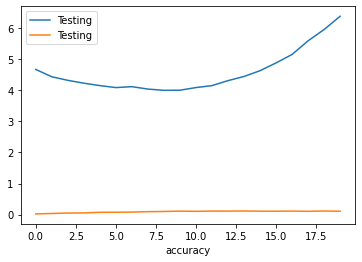

In [104]:
### TODO: visualize train_loss and train_accuracy
### TODO: visualize test_loss and test_accuracy
plt.plot(test_loss_tracker, label='Testing')
plt.xlabel("Loss")
plt.legend()

plt.plot(test_accuracy_tracker, label='Testing')
plt.xlabel("accuracy")
plt.legend()

### 2.3 Ablation study of filters (10 pts)
In practice, for many computer vision tasks, training the network from scratch is not recommended since it is time consuming and requires a vase amount of labeled data for training. Instead, one can use networks trained for image classification on benchmark datasets such as ImageNet to initialize a new network. In particular, the initial layers of the pre-trained networks extract general features and can therefore be used to initialize the initial layers of a new network.

In this part,you will visualize some of the filters from the first layer of [AlexNet](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) and the results of their application on a sample image from the Stanford dogs dataset.

Run the cell below to load a pretrained Alexnet using [PyTorch Hub](https://pytorch.org/docs/stable/hub.html)'s [`torch.hub.load()`](https://pytorch.org/docs/stable/hub.html#torch.hub.load) method. The model is switched to `eval()` as we are using it only for inference. Running this cell will display the architecture of the `Alexnet`.

In [48]:
# load the alexnet model using pytorch hub from:
# https://github.com/pytorch/vision/blob/winbuild/v0.6.0/torchvision/models/alexnet.py
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

# switch the model to "eval" mode
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\Armando/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Armando/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth
10.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

25.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

41.7%IOPub message rate exceeded.
The notebook server will temporarily sto

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Since we are using a pretrained model, our data distribution should match the distribution of the training data. Here, we normalize the input similar to [original training pipeline](https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198).

Run the cell below to load and normalize a sample image.

In [131]:
data,_ = next(iter(train_dl))
sample_image = data[0]

# the mean and standard deviations of ImageNet dataset 
# that were used for preprocessing AlexNet training data
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

### TODO: normalize sample_image using the mean and standard deviations of ImageNet dataset 
sample_image_processed = transforms.Compose([sample_image, transforms.Normalize(mean=mean, std=std)])

TypeError: Image data of dtype object cannot be converted to float

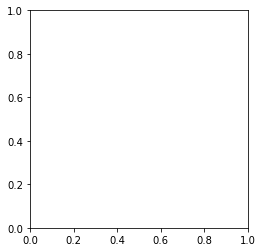

In [128]:
### TODO: visualize the sample image
plt.imshow(sample_image_processed)

Visualize a randomly selected subset of 20 of these first layer filters as well as the respective output of convolving each kernel with a sample image. 

In [53]:
import numpy as np

# first layer of Alexnet
first_layer = model.features[0]

### TODO: get weights of first layer kernels of the model
first_weights = first_layer.weight
### TODO: pass sample image to the first layer

### TODO: randomly select 20 filters out of 64

### TODO: show selected kernel and their convolution output on sample image.


In [93]:
# Save weights from Part 2
path = './q_2_model_weights.pth'
torch.save(model.state_dict(), path)

# Load weights to use for Part 2
# model = conv_net()
# model.load_state_dict(torch.load(path))